In [1]:
import cdh23.loadData
import cdh23.analyzeData
from pathlib import Path
import sys 
import os
import numpy as np
import importlib

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
print(sys.path)
import responses_analysis
import utils
import config

data_path = config.data_path
save_path = config.save_path
if not save_path.exists():
        save_path.mkdir()

colors_ito = {'black':[0,0,0], 'orange':[230,159,0], 'skyblue':[86,180,233], 'green':[0,158,115],
        'yellow':[240,228,66], 'blue':[0,114,178], 'darkorange':[213,94,0], 'purple': [204,121,167]}
colors_ito = {key: (np.array(colors_ito[key])/255).tolist() for key in colors_ito.keys()}
colors = [colors_ito['blue'],colors_ito['skyblue'],colors_ito['green'],colors_ito['yellow'],colors_ito["darkorange"]]
colors

['c:\\Users\\travisb\\Dropbox (Personal)\\Cdh23\\Code\\Travis', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\python39.zip', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\DLLs', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p', '', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages', 'c:\\users\\travisb\\documents\\repos\\suite2p', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\Pythonwin', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\setuptools\\_vendor']


[[0.0, 0.4470588235294118, 0.6980392156862745],
 [0.33725490196078434, 0.7058823529411765, 0.9137254901960784],
 [0.0, 0.6196078431372549, 0.45098039215686275],
 [0.9411764705882353, 0.8941176470588236, 0.25882352941176473],
 [0.8352941176470589, 0.3686274509803922, 0.0]]

In [2]:
###subroutine to reanalyze all mice to get confusion matrices out of the analysis
import cdh23.analyzeData_minimal
import pandas as pd

test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)

accuracies, accuracies_chance, cws_accuracies, cws_chance, confusion_matrices, mice = ([] for i in range(6))

for i, row in twop_mice.iterrows():
    mouse = row['Mouse']
    folds = 10
    data = cdh23.loadData.loadTheData([mouse], data_path)
    ordered = data.processAndSort(mouse)
    analyzer = cdh23.analyzeData_minimal.analyzeTheData(ordered[0][0], ordered[1][0], mouse, "F1_Ahl")
    Xr_sc = analyzer.getZScoredConcat()
    mean_accuracy, mean_accuracy_chance, cw_accuracies, cw_chance, cms = analyzer.kFolds_classify(Xr_sc, folds)

    accuracies.append(mean_accuracy)
    accuracies_chance.append(mean_accuracy_chance)
    cws_accuracies.append(cw_accuracies)
    cws_chance.append(cw_chance)
    confusion_matrices.append(np.stack(cms,axis=-1).sum(axis=-1))
    mice.append(mouse)

df = pd.DataFrame({'Mouse':mice, "mean_accuracy": accuracies, "mean_accuracy_chance":accuracies_chance,
                    'cw_accuracies':cws_accuracies, 'cw_chance':cws_chance, 'confusion_matrix':confusion_matrices})

**/2P/L23/[0-9]* all
------------------
Mouse: m602
------------------
Loading data...
Date: 220317
Calculating dF...
Neurons x Time: (663, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.61
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.04
Classwise accuracy
------------------
Mouse: m603
------------------
Loading data...
Date: 220422
Calculating dF...
Neurons x Time: (704, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.55
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.04
Classwise accuracy
------------------
Mouse: m609
------------------
Loading data...
Date: 220317
Calculating dF...
Neurons x Time: (684, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.28
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.04
Classwise accuracy
------------------
Mouse: m670
------------------
Loading data...
Date: 220422
Calculating dF...
Neurons x Time: (1529, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.82
Chance Accuracy- LDA

In [3]:
# Then, keep going to get the actual data out of there
mice, freqs, attens, accuracy = ([],[],[],[])

for i, row in df.iterrows():
    cw_accuracy = np.array(row['cw_accuracies'])
    cw_accuracy_mean = cw_accuracy.mean(axis=0)*100
    
    index = 0
    for freq in [4,8,16,32,64]:
        for atten in [90,70,50,30]:
            mice.append(row['Mouse'])
            freqs.append(freq)
            attens.append(atten)
            accuracy.append(cw_accuracy_mean[index])
            index += 1

df2 = pd.DataFrame({'Mouse':mice,'frequency':freqs, 'SPL':attens, 'accuracy':accuracy})

In [4]:
df3 = df2.merge(twop_mice, on="Mouse")
df3.head()

,Mouse,frequency,SPL,accuracy,Sex,Genotype,DOB,2P_path
0,m602,4,90,80.0,F,Thy1-GC6s; Cdh23 (Ahl/ahl),12/6/2021,c:\Users\travisb\Dropbox (Personal)\Cdh23\Data...
1,m602,4,70,90.0,F,Thy1-GC6s; Cdh23 (Ahl/ahl),12/6/2021,c:\Users\travisb\Dropbox (Personal)\Cdh23\Data...
2,m602,4,50,30.0,F,Thy1-GC6s; Cdh23 (Ahl/ahl),12/6/2021,c:\Users\travisb\Dropbox (Personal)\Cdh23\Data...
3,m602,4,30,10.0,F,Thy1-GC6s; Cdh23 (Ahl/ahl),12/6/2021,c:\Users\travisb\Dropbox (Personal)\Cdh23\Data...
4,m602,8,90,80.0,F,Thy1-GC6s; Cdh23 (Ahl/ahl),12/6/2021,c:\Users\travisb\Dropbox (Personal)\Cdh23\Data...


In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import stats

model = ols('accuracy ~ C(Genotype) + C(frequency) + C(SPL) + C(SPL):C(Genotype):C(frequency)', data=df3).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),92559.982143,2.0,81.832030,5.069343e-30
C(frequency),36477.619048,4.0,16.124882,3.707658e-12
C(SPL),81499.761905,3.0,48.035813,3.911414e-26
C(SPL):C(Genotype):C(frequency),86562.994048,50.0,3.061204,7.622528e-10
Residual,203597.500000,360.0,NaN,NaN


In [6]:
accuracy_stats = stats.ttests(df3,'frequency','accuracy')
accuracy_stats

,geno1,geno2,frequency,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,82.5000,22.860023,50.9375,40.189822,2.715608e-04,True,8.146824e-04
1,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,76.5625,27.073303,72.8125,32.252469,6.162109e-01,False,7.110126e-01
2,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,80.9375,26.318076,57.8125,43.010454,1.181290e-02,True,2.531336e-02
3,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),32,80.9375,21.153719,27.5000,32.626923,9.763649e-11,True,4.881825e-10
4,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),64,69.6875,24.819916,14.3750,19.664525,2.363263e-14,True,3.544895e-13
5,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),4,82.5000,22.860023,73.0000,25.152168,1.668339e-01,False,2.502509e-01
6,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),8,76.5625,27.073303,72.0000,24.408799,5.423686e-01,False,7.110126e-01
7,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),16,80.9375,26.318076,61.0000,23.597502,8.002732e-03,True,2.000683e-02
8,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),32,80.9375,21.153719,67.0000,22.964504,2.978700e-02,False,5.454747e-02
9,Thy1-GC6s; Cdh23 (Ahl/ahl),(F1) Thy1-GC6s; Cdh23 (Ahl/ahl),64,69.6875,24.819916,66.0000,22.803509,5.933905e-01,False,7.110126e-01


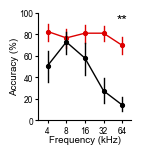

In [13]:
import seaborn as sns
import plotting
import matplotlib.pyplot as plt

df3_2genos = df3[df3['Genotype']!='(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
color_dict = config.color_dict
order = ['Thy1-GC6s; Cdh23 (ahl/ahl)','Thy1-GC6s; Cdh23 (Ahl/ahl)']

fig, ax = plt.subplots(figsize=(1.2,1.4))
sns.pointplot(df3_2genos, x = 'frequency', y= 'accuracy', hue='Genotype', palette=color_dict, linewidth=1, markersize=3)
plt.xlabel("Frequency (kHz)", labelpad=0, fontsize=7)
plt.ylabel ("Accuracy (%)", labelpad=0, fontsize=7)
plt.ylim([0,100])
ax.get_legend().remove()
fig, ax = plotting.figQuality(fig,ax)

## add significant
twogenos = (accuracy_stats['geno1']=='Thy1-GC6s; Cdh23 (Ahl/ahl)') & (accuracy_stats['geno2']=='Thy1-GC6s; Cdh23 (ahl/ahl)')
stats_temp = accuracy_stats[twogenos]
for i, freq in enumerate(stats_temp.frequency.unique()):
    p = stats_temp[stats_temp['frequency']==freq].pval_corrected.values[0]
    plt.text(i,90, plotting.return_stars(p), ha='center')

plt.savefig(save_path / "Fig5_D_frequency_summary.svg")

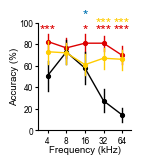

In [8]:
###3 genos
import seaborn as sns
import plotting
import matplotlib.pyplot as plt

color_dict = config.color_dict
order = config.order

fig, ax = plt.subplots(figsize=(1.2,1.4))
sns.pointplot(df3, x = 'frequency', y= 'accuracy', hue='Genotype', palette=color_dict, linewidth=1, markersize=3)
plt.xlabel("Frequency (kHz)", labelpad=0, fontsize=7)
plt.ylabel ("Accuracy (%)", labelpad=0,fontsize=7)
plt.ylim([0,100])
ax.get_legend().remove()
fig, ax = plotting.figQuality(fig,ax)

for i, combo in accuracy_stats[['geno1','geno2']].drop_duplicates().iterrows():
    ## add significant
    if i == 0:
        offset = 90
        color = color_dict['Thy1-GC6s; Cdh23 (Ahl/ahl)']
    elif i == 5:
        offset = 104
        color = '#0072B2'
    elif i == 10:
        offset = 97
        color = color_dict['(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
    twogenos = (accuracy_stats['geno1']==combo['geno1']) & (accuracy_stats['geno2']==combo['geno2'])
    stats_temp = accuracy_stats[twogenos]
    for j, freq in enumerate(stats_temp.frequency.unique()):
        p = stats_temp[stats_temp['frequency']==freq].pval_corrected.values[0]
        plt.text(j,offset, plotting.return_stars(p), ha='center', color = color)

plt.savefig(save_path / "SF2_F_frequency_summary_3genos.svg")

In [9]:
importlib.reload(stats)
accuracy_stats = stats.ttests_2cats(df3,'frequency','SPL', 'accuracy')
accuracy_stats

('Thy1-GC6s; Cdh23 (Ahl/ahl)', 'Thy1-GC6s; Cdh23 (ahl/ahl)')
[ 4  8 16 32 64]
('Thy1-GC6s; Cdh23 (Ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')
[ 4  8 16 32 64]
('Thy1-GC6s; Cdh23 (ahl/ahl)', '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)')
[ 4  8 16 32 64]


,geno1,geno2,frequency,SPL,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,90,87.50,20.528726,95.00,7.559289,3.486565e-01,False,0.550510
1,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,70,95.00,5.345225,67.50,32.841611,3.477317e-02,False,0.083456
2,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,50,76.25,25.035689,27.50,29.154759,2.967921e-03,True,0.014840
3,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,30,71.25,29.001232,13.75,20.658793,4.388105e-04,True,0.003291
4,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,90,92.50,8.864053,92.50,14.880476,1.000000e+00,False,1.000000
5,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,70,90.00,11.952286,93.75,9.161254,4.927854e-01,False,0.671980
6,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,50,70.00,30.237158,66.25,27.222627,7.981242e-01,False,0.938273
7,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,30,53.75,31.139089,38.75,35.228844,3.821391e-01,False,0.573209
8,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,90,93.75,11.877349,93.75,10.606602,1.000000e+00,False,1.000000
9,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,70,95.00,7.559289,77.50,34.121631,1.785577e-01,False,0.345596


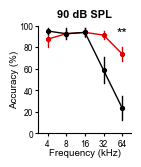

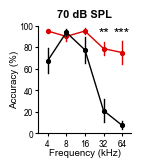

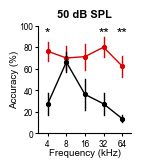

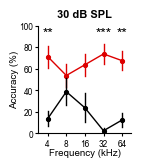

In [10]:
import seaborn as sns
import plotting
import matplotlib.pyplot as plt

df3_2genos = df3[df3['Genotype']!='(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
color_dict = config.color_dict
order = config.order

for SPL in df3['SPL'].unique():
    temp = df3_2genos[df3_2genos['SPL']==SPL]
    fig, ax = plt.subplots(figsize=(1.2,1.4))
    sns.pointplot(temp, x = 'frequency', y= 'accuracy', hue='Genotype', palette=color_dict, linewidth=1, markersize=3, errorbar='se')
    plt.xlabel("Frequency (kHz)", labelpad=0, fontsize=7)
    plt.ylabel ("Accuracy (%)", labelpad=0, fontsize=7)
    plt.ylim([0,100])
    ax.get_legend().remove()
    fig, ax = plotting.figQuality(fig,ax)

    ## add significant
    twogenos = (accuracy_stats['geno1']=='Thy1-GC6s; Cdh23 (Ahl/ahl)') & (accuracy_stats['geno2']=='Thy1-GC6s; Cdh23 (ahl/ahl)')
    twogenos = twogenos & (accuracy_stats['SPL']==SPL)
    stats_temp = accuracy_stats[twogenos]
    for i, freq in enumerate(stats_temp.frequency.unique()):
        p = stats_temp[stats_temp['frequency']==freq].pval_corrected.values[0]
        plt.text(i,90, plotting.return_stars(p), ha='center')

        
    plt.title((str(SPL) + " dB SPL"), fontsize=8, fontweight='bold')
    plt.savefig(save_path / (str(SPL) + "Fig5_E_dbSPL_summary.svg"))

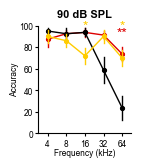

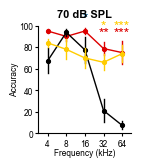

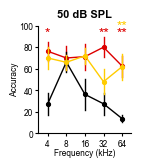

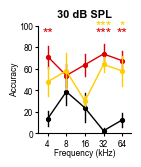

In [11]:
#3 genos
import seaborn as sns
import plotting
import matplotlib.pyplot as plt

color_dict = config.color_dict
order = config.order

for SPL in df3['SPL'].unique():
    temp = df3[df3['SPL']==SPL]
    fig, ax = plt.subplots(figsize=(1.2,1.4))
    sns.pointplot(temp, x = 'frequency', y= 'accuracy', hue='Genotype', palette=color_dict, linewidth=1, markersize=3, errorbar='se')
    plt.xlabel("Frequency (kHz)", labelpad=0)
    plt.ylabel ("Accuracy", labelpad=0)
    plt.ylim([0,100])
    ax.get_legend().remove()
    fig, ax = plotting.figQuality(fig,ax)

    ## add significant
    temp_acc_df = accuracy_stats[accuracy_stats['SPL']== SPL]
    for i, combo in accuracy_stats[['geno1','geno2']].drop_duplicates().iterrows():
        if i == 0:
            offset = 90
            color = color_dict['Thy1-GC6s; Cdh23 (Ahl/ahl)']
        elif i == 20:
            offset = 104
            color = '#0072B2'
        elif i == 40:
            offset = 97
            color = color_dict['(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
        twogenos = (temp_acc_df['geno1']==combo['geno1']) & (temp_acc_df['geno2']==combo['geno2'])
        stats_temp = temp_acc_df[twogenos]
        for j, freq in enumerate(stats_temp.frequency.unique()):
            p = stats_temp[stats_temp['frequency']==freq].pval_corrected.values[0]
            plt.text(j,offset, plotting.return_stars(p), ha='center', color = color)

        
    plt.title((str(SPL) + " dB SPL"), fontsize=8, fontweight='bold')
    plt.savefig(save_path / (str(SPL) + "SP2_G_dbSPL_summary_3genos.svg"))

In [12]:
accuracy_stats

,geno1,geno2,frequency,SPL,mean1,std1,mean2,std2,pval,reject_hs,pval_corrected
0,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,90,87.50,20.528726,95.00,7.559289,3.486565e-01,False,0.550510
1,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,70,95.00,5.345225,67.50,32.841611,3.477317e-02,False,0.083456
2,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,50,76.25,25.035689,27.50,29.154759,2.967921e-03,True,0.014840
3,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),4,30,71.25,29.001232,13.75,20.658793,4.388105e-04,True,0.003291
4,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,90,92.50,8.864053,92.50,14.880476,1.000000e+00,False,1.000000
5,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,70,90.00,11.952286,93.75,9.161254,4.927854e-01,False,0.671980
6,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,50,70.00,30.237158,66.25,27.222627,7.981242e-01,False,0.938273
7,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),8,30,53.75,31.139089,38.75,35.228844,3.821391e-01,False,0.573209
8,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,90,93.75,11.877349,93.75,10.606602,1.000000e+00,False,1.000000
9,Thy1-GC6s; Cdh23 (Ahl/ahl),Thy1-GC6s; Cdh23 (ahl/ahl),16,70,95.00,7.559289,77.50,34.121631,1.785577e-01,False,0.345596
